In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
import numpy as np 
import pandas as pd 
import scanpy as sc

In [3]:
import sys, os
sys.path.append('../src')

from interaction import Interaction

In [4]:
# CLONAL EXPANSION
x_path = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_rna_filtered85.csv'
y_path = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/KIR+TEDDY_Yexpanded_filtered85.csv'
slide_outs = '/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/KIR+TEDDY_filtered85/KIR+TEDDY_filtered85_noint_output/0.01_0.5_out'
tcr_embeddings = np.load('/ix/djishnu/Jane/SLIDESWING/jing_data/KIR+TEDDY/data/ESM2_PCA32_KIR+TEDDY.npy')
y = pd.read_csv(y_path)['Y'].values

# # ANTIGEN SPECIFICITY
# x_path = '/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_rna_MRfilt_forSLIDE.csv'
# y_path = '/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_rna_MRfilt_antigens.csv'
# slide_outs = '/ix/djishnu/Jane/SLIDESWING/alok_data/alok_data12_MRfilt_noint_out/0.01_2_out'
# tcr_embeddings = np.load('/ix/djishnu/Jane/SLIDESWING/alok_data/data/Ins1_InsChg2_vecs_beta_ESM2_PCA16.npy')
# y = pd.read_csv(y_path)['Antigen'].values - 1


In [5]:
machop = Interaction(
    slide_outs, 
    plm_embed=tcr_embeddings, 
    y=y,
    interacts_only=False,
    model='LR'
)

In [6]:
# beta_interaction = machop.compute(fdr=0.5)
# beta_interaction.shape

In [7]:
# from plotting import show_interactions
# show_interactions(machop)

In [8]:
# from plotting import show_effect_sizes

# machop.filter_effect_size()
# show_effect_sizes(machop)

In [9]:
# from plotting import show_filtered

# machop.filter_by_effect()
# show_filtered(machop)

In [10]:
machop.interaction_terms.shape

(10191, 6, 33)

In [11]:
machop.n

10191

In [12]:
machop.get_sig_interactions(fdr=0.5, n_iters=20, thresh=0.8)

100%|██████████| 20/20 [11:51<00:00, 35.56s/it]

Found 28 significant interactions with AUC=0.8068850437769284


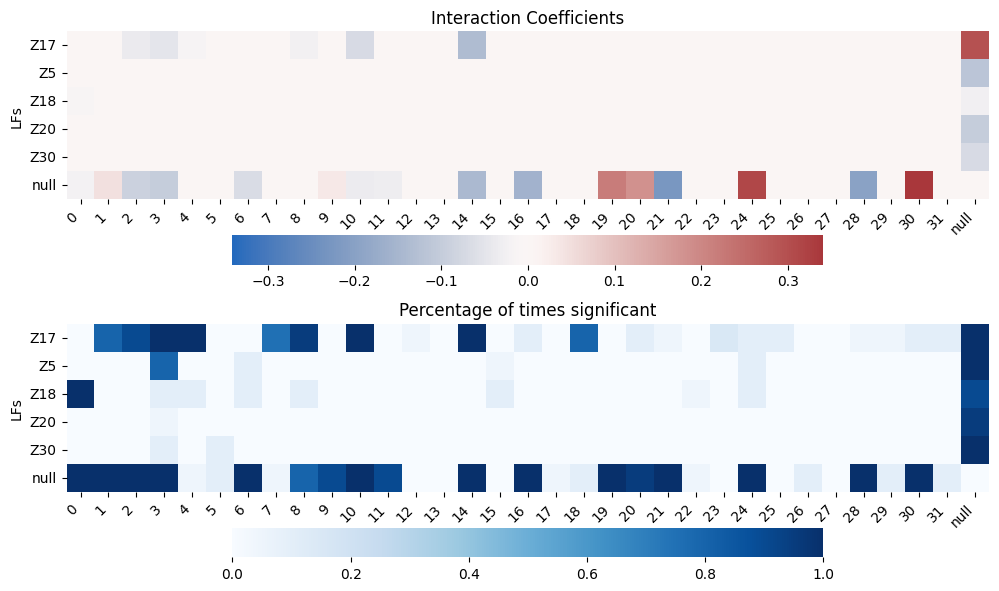

In [13]:
from plotting import show_interactions
show_interactions(machop)

In [14]:
# machop.force_linear_terms(z1=True, z2=True)

In [15]:
machop.get_joint_embed()
joint_embed = machop.joint_embed.copy()
joint_embed.shape

(10191, 28)

In [16]:
full_embed = np.hstack([machop.z_matrix, machop.plm_embedding])
full_embed.shape

(10191, 39)

In [29]:
from models import Estimator
from sklearn.linear_model import Lasso, LinearRegression

model = Lasso(alpha=0.05)
# model = LinearRegression()


In [30]:
estimator = Estimator(model=model)
auc0 = estimator.evaluate(joint_embed, y)

estimator = Estimator(model=model)
auc1 = estimator.evaluate(full_embed, y)

estimator = Estimator(model=model)
auc2 = estimator.evaluate(machop.z_matrix, y)

estimator = Estimator(model=model)
auc3 = estimator.evaluate(machop.plm_embedding, y)

In [31]:
df = pd.DataFrame(
    np.vstack([auc0, auc1, auc2, auc3]),
    index=['joint', 'full', 'z-matrix', 'plm']
)
df.reset_index(inplace=True)
df = df.melt(id_vars='index', var_name='iter', value_name='auc')

In [32]:
def filter_pairs(pairs, df):
    filtered = []
    for i, j in pairs:
        if not np.all(df[df['index'] == i]['auc'].values == df[df['index'] == j]['auc'].values):
            filtered.append((i, j))
    return filtered

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

joint vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01
plm vs. z-matrix: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01
full vs. plm: Kruskal-Wallis independent samples (pairwise between groups), P_val:5.381e-05 Stat=1.631e+01


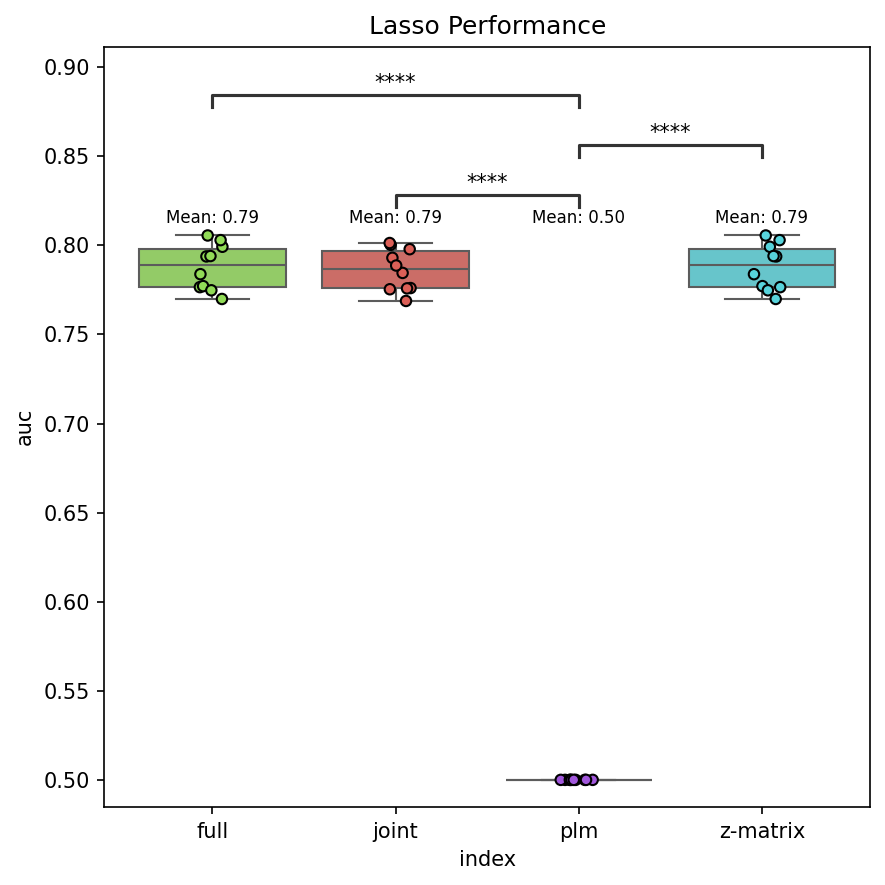

In [34]:
import seaborn as sns 
import matplotlib.pyplot as plt 
from statannotations.Annotator import Annotator
import itertools 

fig, ax = plt.subplots(figsize=(6,6), dpi=150)
order = np.unique(df['index'])

sns.boxplot(data=df, x='index', y='auc', hue='index', palette='hls', ax=ax, showfliers=False, order=order)
sns.stripplot(data=df, x='index', y='auc', hue='index', ax=ax, palette='hls', legend=False, linewidth=1, edgecolor='black', jitter=True)

pairs=list(itertools.combinations(order, 2))
pairs = filter_pairs(pairs, df)

annotator = Annotator(ax, pairs, data=df, x='index', y='auc', order=order)
annotator.configure(test='Kruskal', text_format='star', loc='inside', verbose=2, hide_non_significant=True)
annotator.apply_and_annotate()

means = df.groupby('index')['auc'].mean()
for i, mean in zip(means.index, means):
    plt.text(i, df['auc'].max()+0.005 , f'Mean: {mean:.2f}', ha='center', va='bottom', fontsize=8, color='black')

plt.title(f'{model.__class__.__name__} Performance')
plt.tight_layout()

In [28]:
# from deletion import EmbeddingEvaluator

# evaluator = EmbeddingEvaluator()
# accuracies = evaluator.get_contributions(
#     embedding=machop.plm_embedding, 
#     y=machop.y
# )